In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def load_data(input_file):
    """
    Carrega os dados a partir do arquivo de entrada CSV.
    """
    try:
        data = pd.read_csv(input_file)
        return data
    except FileNotFoundError:
        print("Arquivo não encontrado:", input_file)
        return None
    except pd.errors.EmptyDataError:
        print("O arquivo está vazio:", input_file)
        return None
    except pd.errors.ParserError:
        print("Erro ao ler o arquivo:", input_file)
        return None

In [3]:
def calculate_inflation_adjustment(data, start_year, inflation_rate):
    """
    Ajusta a renda atual dos indivíduos considerando a inflação anual.
    """
    years_since_start = start_year - data['initial_age']
    data['income'] = data['income'] * (1 + inflation_rate)**years_since_start
    return data

In [4]:
def filter_eligible_individuals(data, age_threshold):
    """
    Filtra os indivíduos elegíveis com idade maior ou igual a um valor mínimo.
    """
    data = data[data['initial_age'] >= age_threshold]
    return data

In [5]:
def calculate_additional_savings(data, max_match_amount, income_threshold, retirement_age, years_since_start):
    """
    Calcula as economias adicionais para aposentadoria de cada indivíduo.
    """
    years_until_retirement = retirement_age - (data['initial_age'] + years_since_start)
    eligible_years = np.minimum(years_until_retirement, years_since_start)
    data['additional_savings'] = np.where(
        data['income'] <= income_threshold,
        data['income'] * data['annual_contribution'] * max_match_amount * eligible_years,
        0
    )
    return data

In [6]:
def update_accumulated_capital(data):
    """
    Atualiza o saldo acumulado de cada indivíduo considerando a inflação e as economias adicionais.
    """
    data['new_accumulated_capital'] = data['accumulated_capital'] + data['additional_savings']
    return data

In [7]:
def calculate_retirement_metrics(data):
    """
    Calcula as métricas de preparação para a aposentadoria.
    """
    total_persons = len(data)
    retirement_ready_persons = len(data[data['new_accumulated_capital'] >= 0])
    retirement_readiness_rating = retirement_ready_persons / total_persons
    retirement_savings_shortfall = np.sum(data[data['new_accumulated_capital'] < 0]['new_accumulated_capital']) / total_persons
    return retirement_readiness_rating, retirement_savings_shortfall

In [8]:
def generate_weighted_avg_savings_shortfall_plots(data, race_labels, age_labels):
    """
    Gera os gráficos de média ponderada de deficiência de economias para a aposentadoria por raça e faixa etária.
    """
    age_bins = [35, 39, 44, 49, 54, 59, 64]

    data['age_cohort'] = pd.cut(data['initial_age'], bins=age_bins, labels=age_labels)
    data['race_label'] = data['race'].map({1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Other'})

    grouped_data = data.groupby(['race_label', 'age_cohort'])
    weighted_avg_savings_shortfall = grouped_data['new_accumulated_capital'].mean()

    num_plots = len(race_labels)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8), squeeze=False)

    for i, race in enumerate(race_labels):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row][col]

        race_data = weighted_avg_savings_shortfall.loc[race].reset_index()
        race_data.plot(x='age_cohort', y='new_accumulated_capital', kind='bar', ax=ax)
        ax.set_xlabel('Age Cohort')
        ax.set_ylabel('Weighted Average Retirement Savings Shortfall')
        ax.set_title(f'Weighted Average Retirement Savings Shortfall by Age Cohort - {race}')

    plt.tight_layout()
    plt.savefig('weighted_avg_savings_shortfall_plots.pdf')
    plt.show()

In [9]:
def generate_retirement_readiness_by_age_plot(data, retirement_readiness_rating):
    """
    Gera o gráfico de impacto na Taxa de Preparação para a Aposentadoria por faixa etária.
    """
    retirement_readiness_by_age = data.groupby('age_cohort')['new_accumulated_capital'].apply(lambda x: np.sum(x >= 0) / len(x)).subtract(retirement_readiness_rating).mul(100)
    retirement_readiness_by_age.plot(kind='bar')
    plt.xlabel('Age Cohort')
    plt.ylabel('Impact in Percentage Points')
    plt.title('Impact of the New Scenario on Retirement Readiness Rating per Age Cohort')
    plt.savefig('retirement_readiness_rating.pdf')
    plt.show()

In [10]:
def save_updated_data(data, output_file):
    """
    Salva os dados atualizados em um novo arquivo CSV.
    """
    data[['initial_age', 'weight', 'family_kind', 'race', 'marital_status', 'accumulated_capital', 'annual_contribution', 'income', 'new_accumulated_capital']].to_csv(output_file, index=False)

In [11]:
def main():
    try:
        # Carregar o arquivo de entrada
        input_file = '/data.csv'
        data = load_data(input_file)
        if data is None:
            exit()

        # Definir os parâmetros do programa Saver's Match
        max_match_amount = 0.5 * 10000  # Valor máximo de contrapartida do Saver's Match
        income_threshold = 10000  # Limite de renda para ser elegível ao Saver's Match
        retirement_age = 65  # Idade de aposentadoria
        inflation_rate = 0.044  # Taxa de inflação anual (4.4%)
        start_year = 2020  # Ano inicial da simulação

        # Processar os dados
        data = calculate_inflation_adjustment(data, start_year, inflation_rate)
        data = filter_eligible_individuals(data, 18)
        years_since_start = start_year - data['initial_age']  # Cálculo do years_since_start
        data = calculate_additional_savings(data, max_match_amount, income_threshold, retirement_age, years_since_start)
        data = update_accumulated_capital(data)

        # Calcular métricas de aposentadoria
        retirement_readiness_rating, retirement_savings_shortfall = calculate_retirement_metrics(data)

        # Gerar gráficos
        race_labels = ['White', 'Black', 'Hispanic', 'Other']
        age_labels = ['35-39', '40-44', '45-49', '50-54', '55-59', '60-64']

        generate_weighted_avg_savings_shortfall_plots(data, race_labels, age_labels)
        generate_retirement_readiness_by_age_plot(data, retirement_readiness_rating)

        # Salvar os dados atualizados em um novo arquivo
        output_file = 'new_scenario.csv'
        save_updated_data(data, output_file)

        # Exibir os resultados
        print("Retirement Readiness Rating:", retirement_readiness_rating)
        print("Retirement Savings Shortfall:", retirement_savings_shortfall)
    except Exception as e:
        print("Ocorreu um erro durante a execução do programa:", str(e))


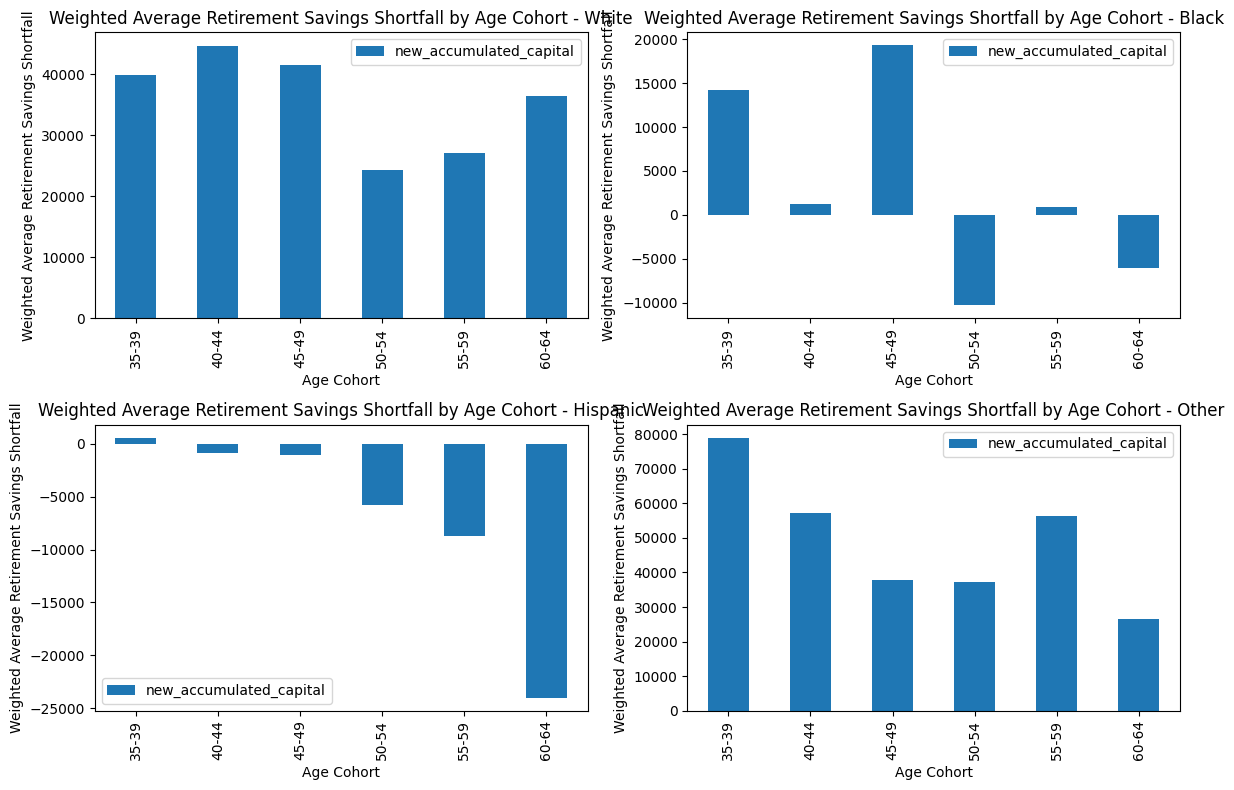

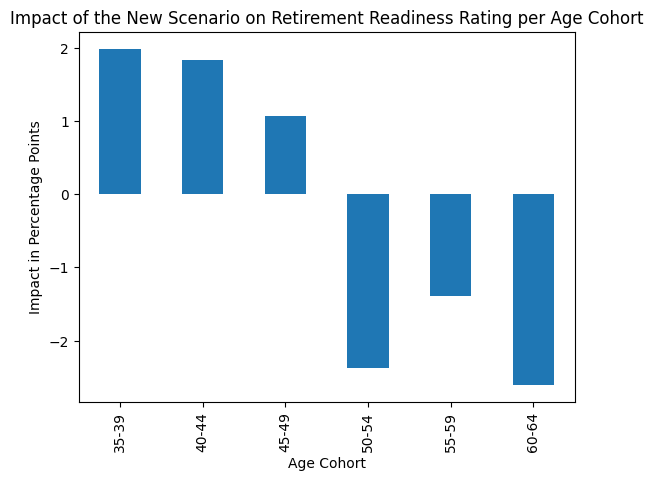

Retirement Readiness Rating: 0.6071375684880794
Retirement Savings Shortfall: -47766.873179477414


In [12]:
main()